In [7]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
# using BenchmarkTools
import ProgressMeter
using LinearAlgebra

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317


In [23]:
# Multivariate update
ReactiveMP.@rule NormalMixture{N}(:out, Marginalisation) (q_switch::Any, q_m::NTuple{N,  MultivariateNormalDistributionsFamily}, q_p::NTuple{N, Wishart }) where { N } = begin
    πs = probvec(q_switch)
    d  = ndims(first(q_m))
    w  = mapreduce(x -> x[1]*mean(x[2]), +, zip(πs, q_p))
    xi = mapreduce(x -> x[1]*mean(x[2])*mean(x[3]), +, zip(πs, q_p, q_m))
    return MvNormalWeightedMeanPrecision(xi, w)
end

In [51]:
using Optim

function my_optimizer(::Type{ Univariate }, ::Type{ Continuous }, constraint::PointMassFormConstraint, distribution)
    target = let distribution = distribution 
        (x) -> -logpdf(distribution, x[1])
    end
    support = Distributions.support(distribution)
    result = if isinf(Distributions.minimum(support)) && isinf(Distributions.maximum(support))
        optimize(target, call_starting_point(constraint, distribution), LBFGS())
    else
        lb = [ Distributions.minimum(support) ]
        rb = [ Distributions.maximum(support) ]
        optimize(target, lb, rb, call_starting_point(constraint, distribution), Fminbox(GradientDescent()))
    end
    return PointMass(Optim.minimizer(result)[1])
end

my_optimizer (generic function with 1 method)

## Switching AR

In [180]:
@model [ default_factorisation = MeanField() ] function switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                     priors_as, priors_bs,
                                                                     priors_ms, priors_ws)

    n = length(outputs)
    A ~ MatrixDirichlet(ones(nmixtures, nmixtures))

    z_0 ~ Categorical(fill(1.0 / nmixtures, nmixtures))

    as = randomvar(nmixtures, prod_constraint = ProdGeneric(), form_constraint = PointMassFormConstraint(optimizer = my_optimizer, starting_point = (_, _, _, dist) -> [ mean(ReactiveMP.getleft(dist)) ]))
    bs = randomvar(nmixtures)
    ms = randomvar(nmixtures)
    ws = randomvar(nmixtures)

    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
        ms[i] ~ MvNormalMeanCovariance(mean(priors_ms[i]), cov(priors_ms[i]))
        ws[i] ~ Wishart(priors_ws[i][1], priors_ws[i][2])
    end

    z  = randomvar(nbuckets)
    γ  = randomvar(nbuckets)
    θ  = randomvar(nbuckets)
    dp = randomvar(n)
    x  = datavar(Vector{Float64}, n)
    y  = datavar(Float64, n)

    tas = tuple(as...)
    tbs = tuple(bs...)
    tms = tuple(ms...)
    tws = tuple(ws...)

    z_prev = z_0
    for i in 1:nbuckets
        z[i] ~ Transition(z_prev, A) where { q = q(out, in)q(a) }
        γ[i] ~ GammaMixture(z[i], tas, tbs)
        θ[i] ~ GaussianMixture(z[i], tms, tws) where { q = MeanField() }
        z_prev = z[i]
    end
    
    k = div(n + ARorder, nbuckets)

    for i in 1:n
        r     = div(i - 1, k) + 1
        dp[i] ~ dot(x[i], θ[r])
        y[i]  ~ NormalMeanPrecision(dp[i], γ[r]) 
    end

    scheduler = schedule_updates(as, bs, ms, ws)
#     scheduler = schedule_updates(ms, ws, as, bs, z, θ, γ, A)

    return scheduler, z, A, as, bs, ms, ws, θ, γ, y, x
end

switching_ar (generic function with 1 method)

In [181]:
function inference_ar(inputs, outputs, nmixtures, nbuckets, n_its, priors_as, priors_bs, priors_ms, priors_ws)
    n = length(outputs)
    ARorder = size(priors_ms[1])[1]

    model, (scheduler, z, A, as, bs, ms, ws, θs, γs, y, x) = switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                          priors_as, priors_bs,
                                                                          priors_ms, priors_ws, options=(limit_stack_depth=100,));
    

    mzs     = keep(Vector{Marginal})
    mA      = keep(Marginal)
    mas     = keep(Vector{Marginal})
    mbs     = keep(Vector{Marginal})
    mms     = keep(Vector{Marginal})
    mws     = keep(Vector{Marginal})
    mθs     = keep(Vector{Marginal})
    mγs     = keep(Vector{Marginal})
    fe      = ScoreActor(Float64)

    mA_sub     = subscribe!(getmarginal(A), mA)
    mz_sub     = subscribe!(getmarginals(z), mzs)
    as_sub     = subscribe!(getmarginals(as), mas)
    bs_sub     = subscribe!(getmarginals(bs), mbs)
    ms_sub     = subscribe!(getmarginals(ms), mms)
    ws_sub     = subscribe!(getmarginals(bs), mws)
    θs_sub     = subscribe!(getmarginals(θs), mθs)
    γs_sub     = subscribe!(getmarginals(γs), mγs)

    # fe_scheduler = PendingScheduler()
    fe_sub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    setmarginal!(A, vague(MatrixDirichlet, (nmixtures, nmixtures)))

    for (i, (a, b, m, w)) in enumerate(zip(as, bs, ms, ws))
        setmarginal!(a, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(b, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(m, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(w, vague(Wishart, ARorder))
    end

    for (θ, γ) in zip(θs, γs)
        setmarginal!(θ, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(γ, vague(Gamma))
    end

    release!(scheduler)
    
    ProgressMeter.@showprogress for i in 1:n_its
        update!(x, inputs)
        update!(y, outputs)
        release!(scheduler)
        # release!(fe_scheduler)
    end


    return map(getvalues, (mzs, mγs, mθs, mA, mas, mbs, mms, mws, fe))
end

inference_ar (generic function with 1 method)

In [182]:
ReactiveMP.release!(::Nothing) = nothing

In [183]:
# cherry picking
# seed 22
γs = [1.0, 0.1]
θs = [[0.3, 0.1], [0.1, -0.2]]

γs = [1.0, 1.0]
θs = [[-0.3, 0.5], [0.1, -0.2]]

2-element Vector{Vector{Float64}}:
 [-0.3, 0.5]
 [0.1, -0.2]

## Generate AR

In [238]:
using Random
Random.seed!(22)

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions

γs = [100.0, 100.0]
θs = [[-0.07928400298953064, -0.04043703882347399], [0.23477507350066362, -0.01932557968735344]]
γs = [1.0, 1.0]
θs = [[-0.3, -0.5], [0.15, 0.2]]
ARorder = length(first(θs))

@assert length(γs) == length(θs)

nmixtures = length(γs)
n_samples = 5000
x = ones(ARorder)
# x = [1.0, 2.0]

n_slice_n = 500

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end

inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
;

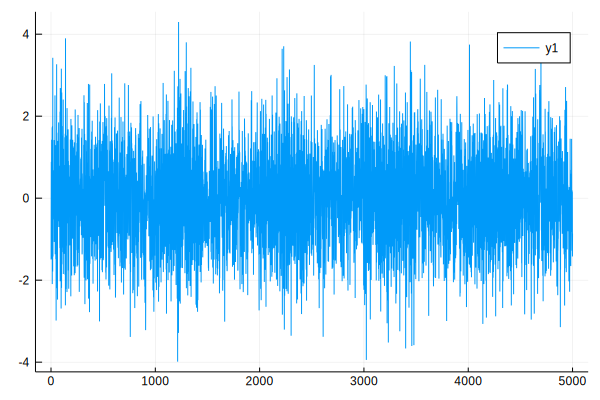

In [239]:
using Plots
plot(outputs)

In [240]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:end-ARorder]

4998-element Vector{Float64}:
 -1.4947245641162321
 -0.24228024173511795
  0.8856970876319681
 -0.6440582270758931
  0.6140822884910634
  1.4262380741171665
  0.6916335714869797
 -1.4715248417089344
 -0.20885569102701562
  0.7380202845869052
  1.728511854090641
 -2.0946545072327893
  1.0155351400136632
  ⋮
 -1.279966546041309
 -0.7434078765711561
 -0.12024702734521414
 -0.6371818554063496
  1.4471852002596457
 -0.020531902630730042
 -0.3802005930674196
 -0.8235142606652923
 -0.7223058333963673
  0.18832200021371343
 -0.5933533320700731
  0.14819910664775535

In [241]:
csep = 10.0

priors_as = map(γ -> infgamma(Float64, γ*csep), γs)
priors_bs = map(_ -> infgamma(Float64, csep), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ, diageye(ARorder)), θs)
priors_ws = map(_ -> (ARorder, 1e4*diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))

@time mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_ar(inputs_, outputs_, nmixtures, 500, 500, priors_as, priors_bs, priors_ms, priors_ws);

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

151.836667 seconds (874.93 M allocations: 51.166 GiB, 17.99% gc time, 0.06% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:02:31


In [242]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.519255  0.516443
 0.480745  0.483557

In [243]:
minimum(mean.(mγs[end]))

0.6131648355420001

In [244]:
mean.(mθs[end])

500-element Vector{Vector{Float64}}:
 [-0.19466011536727756, -0.37012171194843013]
 [-0.34655999777144386, -0.6200986359637688]
 [0.013456621714933448, -0.018732860026883014]
 [-0.11553015811561573, -0.23779170661488802]
 [-0.31548995559856197, -0.568252982249347]
 [-0.31385606393368914, -0.5671769332211661]
 [-0.16069779570812648, -0.3125113606791512]
 [-0.17386093282648973, -0.3334645973842103]
 [-0.34265082856109164, -0.6185974907587264]
 [-0.20683541168574415, -0.3905438562898934]
 [-0.2669293692290601, -0.49189065351555517]
 [-0.2940321470691468, -0.5345234604004738]
 [-0.016975802035925858, -0.070801294279633]
 ⋮
 [0.037525039607050115, 0.022321563176559422]
 [0.08641523495996029, 0.10147016428530464]
 [-0.04141346637903265, -0.11236205986601666]
 [-0.046734802307660805, -0.12116980083021023]
 [0.15448711340915355, 0.21997338319744597]
 [-0.18135188417464132, -0.34523464338631205]
 [0.016816536972060647, -0.014280377405793354]
 [0.009892599861974771, -0.026411340720782217]
 [0.08

In [245]:
using Plots

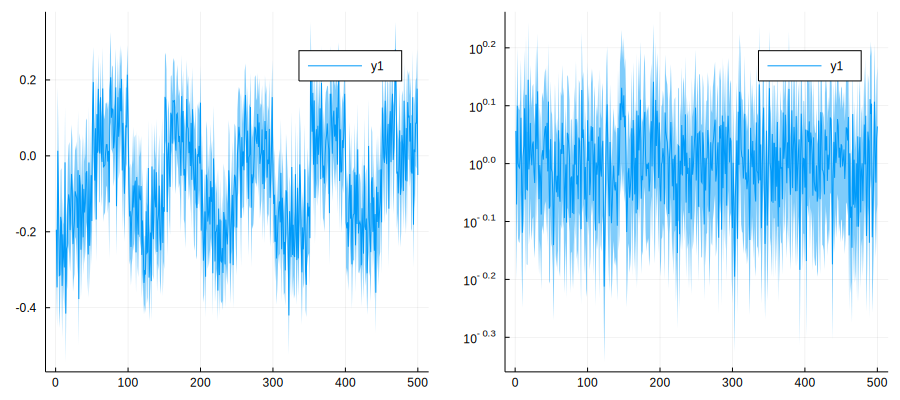

In [248]:
dim(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dim(index), ribbon = std.(mθs[end]) |> dim(index))
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10)

plot(p1, p2, size = (900, 400))

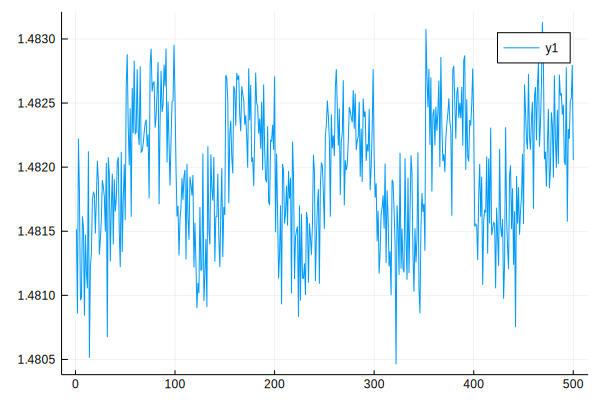

In [247]:
plot(mean.(mzs[end]))

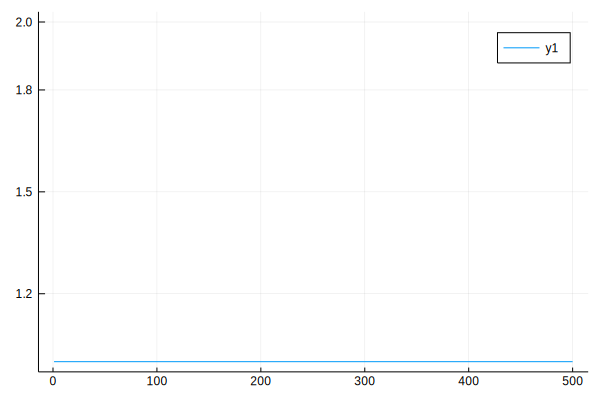

In [250]:
plot(round.(mean.(mzs[end])))

In [234]:
mean.(mzs[end])

500-element Vector{Float64}:
 1.4920949877143346
 1.491427716629298
 1.4927810036000673
 1.4923362056674687
 1.4915338079430231
 1.4915441822497961
 1.492153419335946
 1.4920871653333765
 1.491420963105283
 1.491986736530486
 1.4917322443085725
 1.4916268362649479
 1.4926703150232
 ⋮
 1.4929407263539836
 1.4930727489538151
 1.4926111677095233
 1.4925907416999473
 1.4933241962508008
 1.492114530522525
 1.492839158503267
 1.4927990144489767
 1.4930876109307603
 1.4931027851114766
 1.4933973168747114
 1.4925994901097663

mfe[end - 4:end] = [7443.665524250488, 7443.633512243099, 7443.602012488567, 7443.571010730982, 7443.540493324626]


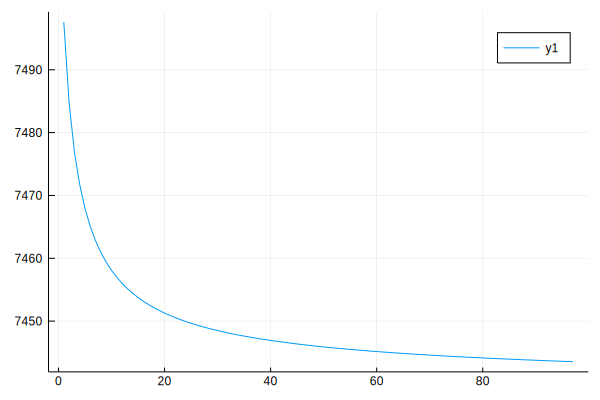

In [235]:
@show mfe[end-4:end]
plot(mfe[4:end])